# Copycat Layout via CyREST
This python notebook gives instructions and sample code for calling copycat layout through Cytoscape CyREST endpoints.

### Requirements:
1. [Install Cytoscape](http://cytoscape.org/download.php) and run the application
    1. Copycat Layout is a core app in 3.6.0 and is available upon installation. If not already installed, get it from the [App store](http://apps.cytoscape.org/apps/copycatlayout)
    
2. Verify that your CyREST TCP/IP port has not been changed. To check, open Cytoscape, go to `Edit>Preferences>Properties` and look for the `rest.port` property. The default port is `1234`. Set the `REST_PORT` variable below to that value
3. Install the requests python module via PyPi by running `pip install requests` in the terminal

Follow the code in this notebook to utilize the Copycat Layout via python scripts!

In [1]:
REST_PORT='1234' # Set to whatever rest.port is in Cytoscape preferences
REST_ENDPOINT = "http://localhost:{}/v1".format(REST_PORT)
import requests
import json
import os
from urllib.request import urlretrieve
from IPython.display import Image, display, HTML

### 1. Verify that CyREST is running,
We can do this by calling the bare CyREST endpoint and checking the version.

In [2]:
response = requests.get(REST_ENDPOINT)
js_resp = response.json()
assert js_resp['apiVersion'] == 'v1', \
    "This notebook uses CyREST API v1, but version {} was found.".format(js_resp['apiVersion'])

print("CyREST v1 is running!")

CyREST v1 is running!


### 2. Load the sample session into Cytoscape

#### The sample.cys file must be located in the same directory as this notebook to be loaded by the cell below
The sample.cys session file located within this repo contains 2 networks. Images of the networks will be displayed below.  Note that the `sample_modified` network is a clone of the `sample` network, with the `H` node removed, and nodes `N` and `O` appended to the network. Edges were added connecting the new nodes, and an edge from `G`->`M` was removed.

In [3]:
# Load sample session
path = os.path.join(os.getcwd(), 'sample.cys')
print("Loading sample at " + path)
session_data = {'file': path}
# 
resp = requests.get(REST_ENDPOINT + "/session", params=session_data)
assert 'message' not in resp.json(), resp.json()['message']

print("Load successful. Check Cytoscape to see two networks")

Loading sample at /Users/bsettle/git/copycat-layout/notebooks/sample.cys
Load successful. Check Cytoscape to see two networks


### 3. Get network and view SUIDs from Cytoscape
We could use hard coded values for the SUIDs, but it makes more sense to use CyREST calls to get the SUIDs, as they are not consistent between session loads.

A few REST calls are made to get the SUIDs of both networks and their primary views, all stored in the `suid_map` python dictionary as `{source, target}`

In [4]:
resp = requests.get(REST_ENDPOINT + "/networks")
network_suids = resp.json()
suid_map = {'source': {'suid': network_suids[0]}, 'target': {'suid': network_suids[1]}}

resp = requests.get("{}/networks/{}/views".format(REST_ENDPOINT, suid_map['source']['suid']))
suid_map['source']['view_suid'] = resp.json()[0] # only one view exists

resp = requests.get("{}/networks/{}/views".format(REST_ENDPOINT, suid_map['target']['suid']))
suid_map['target']['view_suid'] = resp.json()[0] # only one view exists

display(suid_map)

{'source': {'suid': 976, 'view_suid': 1210},
 'target': {'suid': 1058, 'view_suid': 1153}}

#### EXTRA: Display network views in the notebook
The `views/{viewSUID}.png` endpoint returns an image of the network view so we can see how different our networks are.  Looking at the two images below, it would take significant time to realize that the networks are nearly identical.
Copycat Layout will fix that!

Source Network View (SUID=1210)


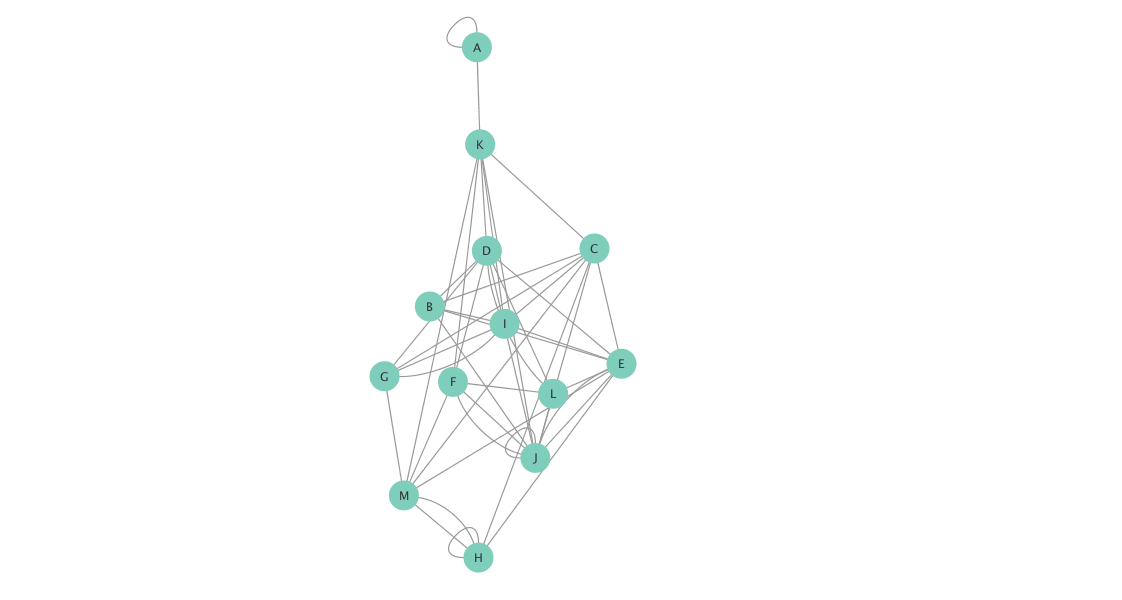

Target Network View (SUID=1153)


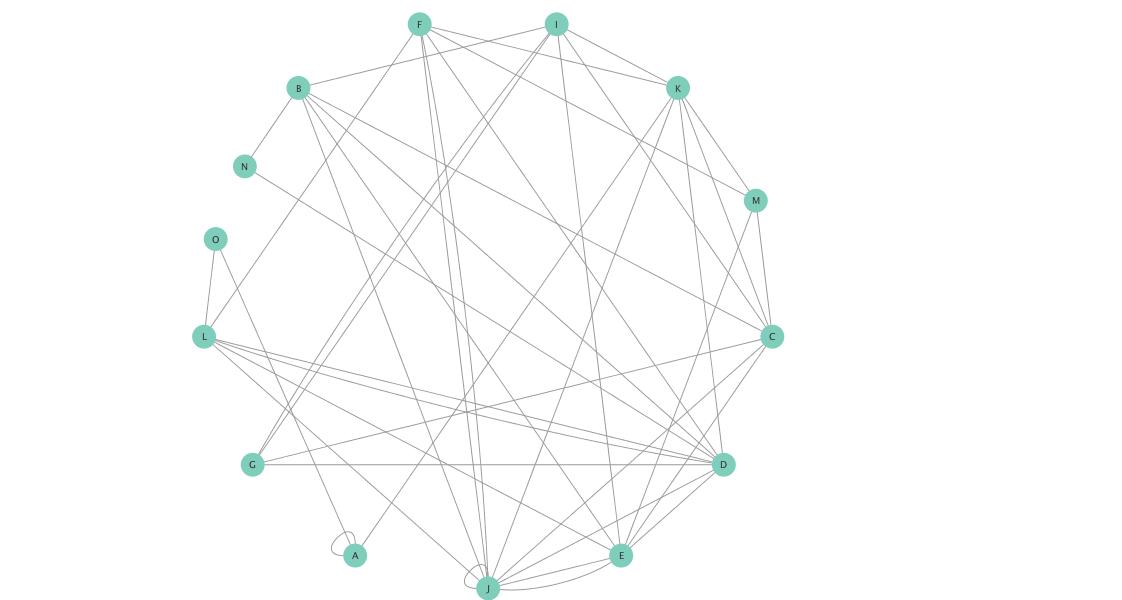

In [5]:
VIEWS = 0 # handles cached images
def show_networks(prefix):
    global VIEWS
    sourceSUID = suid_map['source']['suid']
    sourceViewSUID = suid_map['source']['view_suid']
    targetSUID = suid_map['target']['suid']
    targetViewSUID = suid_map['target']['view_suid']
    
    print("Source Network View (SUID={})".format(sourceViewSUID))
    url1 = "{}/networks/{}/views/{}.png?view={}".format(REST_ENDPOINT, sourceSUID, sourceViewSUID, VIEWS)
    urlretrieve(url1, prefix + "-imA.jpg")
    im1 = Image(filename=prefix + "-imA.jpg")
    display(im1)
    print("Target Network View (SUID={})".format(targetViewSUID))
    url2 = "{}/networks/{}/views/{}.png?view={}".format(REST_ENDPOINT, targetSUID, targetViewSUID, VIEWS)
    urlretrieve(url2, prefix + "-imB.jpg")
    im2 = Image(filename=prefix + "-imB.jpg")
    display(im2)
    
    VIEWS += 1
    
show_networks("pre")

### 4. Apply Copycat Layout
We are going to map node locations form the source network to the target, using the `name` column in each network to pair nodes.  Upon completion, the node named 'A' in the target network will be in the same exact location as the 'A' node in the source network.  The `'selectUnmapped'` parameter is set to `True`, highlighting the differences between the two networks. Currently only unmapped nodes are highlighted.

In [6]:
# Prepare layout data
data = {
  'sourceColumn': 'name',
  'targetColumn': 'name',
  'selectUnmapped': True,
  'gridUnmapped': False
}

headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json'
}
resp = requests.put("{}/apply/layouts/copycat/{}/{}".format(REST_ENDPOINT, \
            suid_map['source']['view_suid'], suid_map['target']['view_suid']), data=json.dumps(data), headers=headers)
data = resp.json()['data']

print("Mapped {} nodes, left {} unmapped in the target network".format(data['mappedNodeCount'], data['unmappedNodeCount']))

Mapped 12 nodes, left 2 unmapped in the target network


### Compare the networks now
The minor differences between the two networks are much easier to see at a glance. The unmapped nodes are highlighted, and can easily be dragged off to the side, or apply a different layout (eg GridLayout).

Source Network View (SUID=1210)


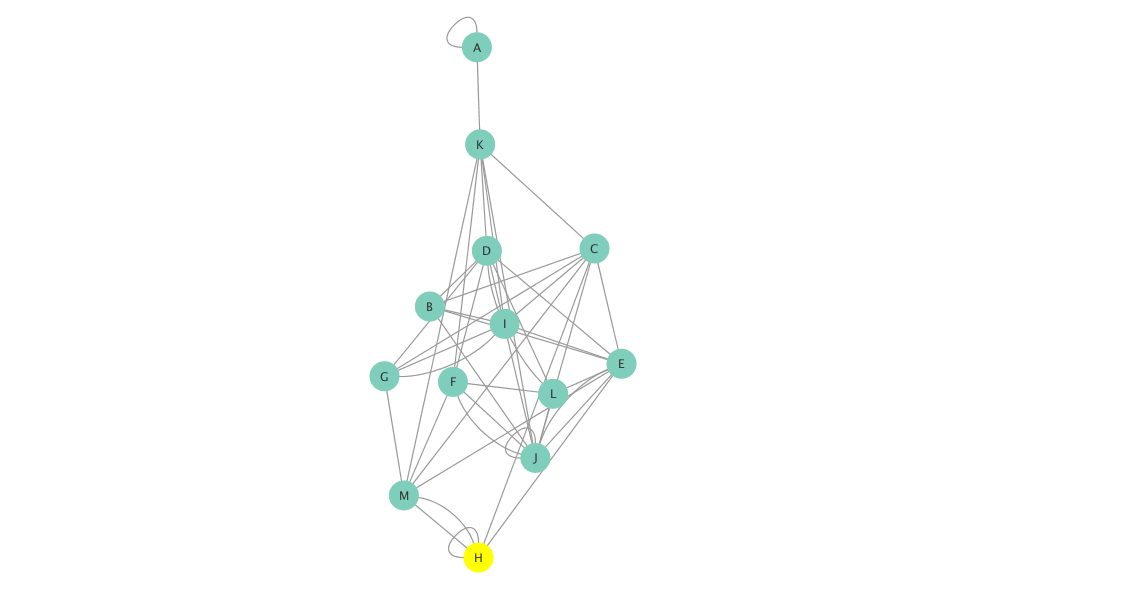

Target Network View (SUID=1153)


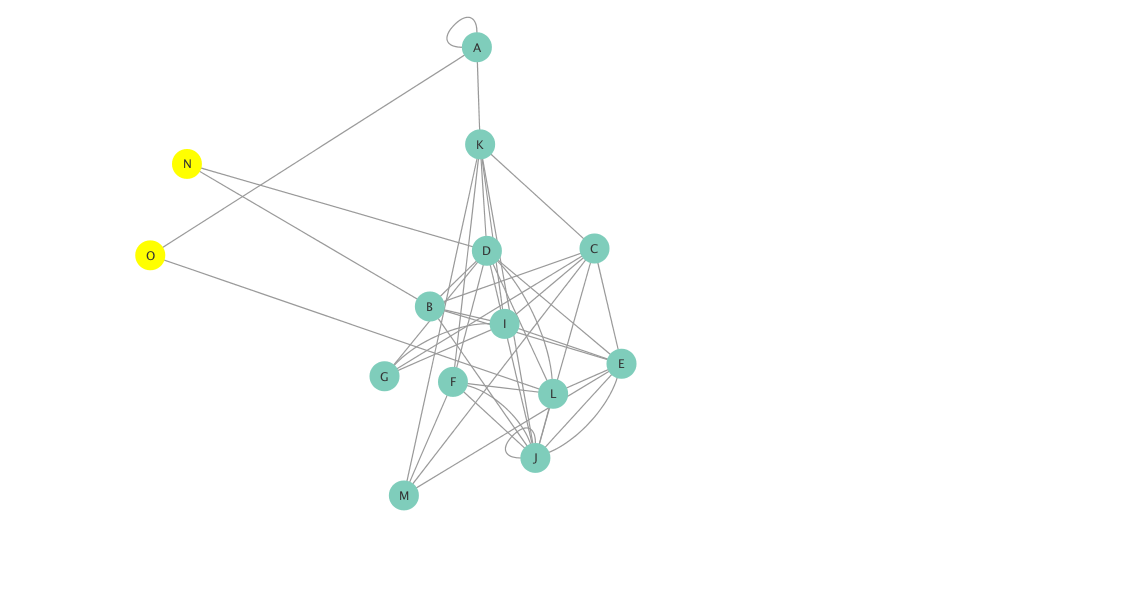

In [7]:
show_networks("post")

### 5. BONUS. Get unmapped nodes
We can use other CyREST endpoints to get the unmapped nodes that were selected by the previous step, and use them in out automation

In [8]:
def getSelectedNodes(networkId):
    resp = requests.get("{}/networks/{}/nodes/selected".format(REST_ENDPOINT, networkId))
    nodes = []
    for nodeId in resp.json():
        resp = requests.get("{}/networks/{}/nodes/{}".format(REST_ENDPOINT, networkId, nodeId))
        nodes.append(resp.json())
    return nodes
    
unmappedSourceNodes = getSelectedNodes(suid_map['source']['suid'])
print("Unmapped Source Nodes: ")
display(unmappedSourceNodes)
unmappedTargetNodes = getSelectedNodes(suid_map['target']['suid'])
print("Unmapped Target Nodes: ")
display(unmappedTargetNodes)


Unmapped Source Nodes: 


[{'data': {'SUID': 993,
   'Type': 'SourceNode',
   'id': 993,
   'name': 'H',
   'selected': True,
   'shared name': 'H'}}]

Unmapped Target Nodes: 


[{'data': {'SUID': 1068,
   'Type': '',
   'id': 1068,
   'name': 'O',
   'selected': True,
   'shared name': 'O'}},
 {'data': {'SUID': 1081,
   'Type': '',
   'id': 1081,
   'name': 'N',
   'selected': True,
   'shared name': 'N'}}]

### Conclusion
Now that the named nodes have been aligned, we can clearly see that nodes N and O are not in the first network, and node H is not in the second. We even used the `selectUnmapped` parameter to get those nodes in our script. Looking at the network images, we can also see that the edge between G and M has been removed.

We could adjust our data to rename those nodes to align with the original network and apply copycat again, or further calculate the aligned edges and style aligned nodes/edges to a specific color for better visibility.

Aligning networks is extremely useful when visualizing multiple steps of a process, to identify changes in each step. It can also be useful to look at groups of homologous genes, visually aligning them to bring focus to unique edges and pathways between the two networks.